
# Visualising Sarcoma Data With Dimensional Reduction

__U21043316__


## Set-up Variables


Select the clinical feature to observe on the RNASeq data:
- gender
- status
- radiation_therapy
- race
- residual_tumor
- histological_type
- ethnicity
- years_to_birth
- overall_survival/overallsurvival

In [53]:
feature = "radiation_therapy" # Change this to the name of an attribute in the clinical data
age_buckets = False # Over-rides feature to explore ages
custom_legend = True


## Imports


In [54]:
import numpy
import pandas
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

In [55]:
## Read data
seq_data_raw = pandas.read_csv("Human_TCGA_SARC_UNC_RNAseq_HiSeq_RNA_01_28_2016_BI_Gene_RSEM_log2.cct.csv", index_col = 0)
#seq_data_raw = pandas.read_csv("Human__TCGA_GBMLGG__UNC__RNAseq__HiSeq_RNA__01_28_2016__BI__Gene__Firehose_RSEM_log2.cct.csv", index_col = 0)
seq_labels_raw = seq_data_raw.columns

clinical_data_raw = pandas.read_csv("Human_TCGA_SARC_MS_Clinical_01_28_2016_BI.tsi.csv", index_col = 0)
#clinical_data_raw = pandas.read_csv("Human__TCGA_GBMLGG__MS__Clinical__Clinical__01_28_2016__BI__Clinical__Firehose.tsi.csv", index_col = 0)
clinical_labels_raw = clinical_data_raw.columns


## Data Pre-Processing


Sarcoma TCGA data was downloaded from LinkOmics, this data included both the Clinical Annotation and the RNASeq matrix. Details on the data is as follows...
- Clinical Annotation   |   261 Samples |  9 Attributes     |   .tsi (mixed data matrix)
- RNASeq                |   259 Samples |  20055 Attributes |   .cct (continuous data matrix)   | normalised log2 RPKM

For this project the RNASeq data is the focus and to it had to converted from .cct to .csv for python manipulation.

Each sample is identified by a name like "TCGA.3B.A9HI" where the first reference the cancer genome project the second references the TSS and the the third represents the participant.


In [56]:
## Remove entries from clinical data not in RNAseq data
participants_not_sequenced = list(set(clinical_labels_raw).difference(seq_labels_raw)) # Entries in Clinical but not RNASeq are returned
clinical_data = clinical_data_raw.drop(participants_not_sequenced, axis='columns')
clinical_labels = clinical_data.columns

## Remove entries from RNAseq data not in clinical data
participants_not_recorded_clinical = list(set(seq_labels_raw).difference(clinical_labels_raw)) # Entries in Clinical but not RNASeq are returned
seq_data = seq_data_raw.drop(participants_not_recorded_clinical, axis='columns')
seq_labels = seq_data.columns

seq_data_transposed = numpy.transpose(seq_data)

Here we can select the feature from the clinical dataset to analyse on the reduced RNASeq...

In [57]:
## Get significant information from clinical data

if(age_buckets):
    ages = [float(x) for x in clinical_data.loc['years_to_birth']]
    age_bins = [0,18,40,60,70,80,150]
    age_labels = ["Child","Adult", "40-60", "60-70", "70-80", "80+"]
    age_labels_numerical = [0,1,2,3,4,5]
    ages_sorted = pandas.DataFrame(pandas.cut(ages, bins=age_bins, labels=age_labels_numerical, right=False), columns = ['AgeRange'])
    general = ages_sorted["AgeRange"].cat.add_categories(-1).fillna(-1).tolist()
    legend = age_labels
else:
    general_df = clinical_data.loc[feature].to_frame()
    general_df[feature] = general_df.astype('category')
    general_df["code"] = general_df[feature].cat.codes
    general = general_df["code"].tolist()
    legend = general_df[feature].cat.categories.tolist()

if(custom_legend):
    print(legend)
    legend = ["No radiation therapy", "Had radiation therapy"]


studied_feature = general

['no', 'yes']



## Principle Component Analysis


For this project, principle component analysis (PCA) is required as a first step before applying tSNE/UMAP. PCA should be used to reduce the number of components down to ??? which is importantly more than two as PCA has poor performance reducing complexity to just two dimensions.


In [58]:
## PCA Information Preservation Matrix
scree_pca = PCA(n_components=seq_data.shape[1])
data_pca_scree = scree_pca.fit_transform(seq_data_transposed)
var_per = scree_pca.explained_variance_/numpy.sum(scree_pca.explained_variance_)
cum_sum = numpy.cumsum(var_per) * 100
# plt.figure(1,figsize=(6,4))
# plt.clf()
# plt.plot(cum_sum,linewidth=2)
# plt.grid()
# plt.xlabel('Number of Principle Components')
# plt.ylabel('Cumulative Variance (%)')
# plt.title('Variance Explained By Each Component')
# plt.show()


# Use this plot to determine amount of 
# components for optimal data preservation

In [59]:
## PCA dimension reduction
pca = PCA(n_components=50)
data_pca = pca.fit_transform(seq_data_transposed)

## PCA Data Visualisation, create a PCA data frame
figure_pca = pandas.DataFrame(data_pca)
figure_pca.index = seq_data_transposed.index
figure_pca.columns = [f"PC{i+1}" for i in range(figure_pca.shape[1])]
figure_pca["code"] = studied_feature
# for code in range(len(legend)):
#     temp = figure_pca[figure_pca["code"] == code]
#     plt.scatter(temp['PC1'], temp['PC2'])

# plt.legend(legend, loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.title("PCA Dimension Reduction (View of 2 PCs)")
# plt.show()

In [60]:
rnaseq_data_shape = seq_data_transposed.shape
rnaseq_pca_shape = data_pca.shape
print(f"Initial data has {rnaseq_data_shape[0]} samples with {rnaseq_data_shape[1]} attributes")
print(f"Data with PCA applied has {rnaseq_pca_shape[0]} samples with {rnaseq_pca_shape[1]} attributes")

Initial data has 259 samples with 20055 attributes
Data with PCA applied has 259 samples with 50 attributes



## Uniform Manifold Approximation Projection & t-Distribution Stochastic Neighbour Embedding


__tSNE__

need to better consider perplexity:
- Perplexity: Check the perplexity parameter used during t-SNE. Perplexity controls the balance between preserving local and global structures. If the perplexity is too small, t-SNE may produce disc-like blobs. Adjusting the perplexity can impact the quality of the visualization. (https://stackoverflow.com/questions/67673905/how-we-can-check-if-tsne-results-are-real-when-we-cluster-data)

Topological Analysis: Examine the resulting clusters. If t-SNE produces a continuous “pie” shape rather than distinct groups, it might indicate poor learning. Adjusting t-SNE parameters or using alternative clustering algorithms (e.g., DBSCAN) could help. (https://stackoverflow.com/questions/67673905/how-we-can-check-if-tsne-results-are-real-when-we-cluster-data)

In [61]:
## tSNE dimension reduction
tsne = TSNE(n_components=2, random_state=123, perplexity=50) ## Not learning_rate is also a parameter
data_tsne = tsne.fit_transform(figure_pca)

## tSNE Data Visualisation
figure_tsne = pandas.DataFrame(data = data_tsne, columns = ['tSNE1', 'tSNE2'])
figure_tsne["code"] = studied_feature
# for code in range(len(legend)):
#     temp = figure_tsne[figure_tsne["code"] == code]
#     plt.scatter(temp['tSNE1'], temp['tSNE2'])
# plt.legend(legend, loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlabel("tSNE1")
# plt.ylabel("tSNE2")
# plt.title("tSNE + PCA Dimensional Reduction")
# plt.show()

In [62]:
rnaseq_tSNE_shape = data_tsne.shape
print(f"Data with PCA + tSNE applied has {rnaseq_tSNE_shape[0]} samples with {rnaseq_tSNE_shape[1]} attributes")

Data with PCA + tSNE applied has 259 samples with 2 attributes


__UMAP__

In [63]:
## UMAP dimension reduction
umap_instance = umap.UMAP(n_neighbors = 30, min_dist = 0.01, metric='manhattan', random_state = 123)
data_umap = umap_instance.fit_transform(figure_pca)

## UMAP Data Visualisation
figure_umap = pandas.DataFrame(data = data_umap, columns = ['UMAP-1', 'UMAP-2'])
figure_umap["code"] = studied_feature
# for code in range(len(legend)):
#     temp = figure_umap[figure_umap["code"] == code]
#     plt.scatter(temp['UMAP-1'], temp['UMAP-2'])
# plt.legend(legend, loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlabel("UMAP-1")
# plt.ylabel("UMAP-2")
# plt.title("UMAP + PCA Dimensional Reduction")
# plt.show()

c:\Users\joele\JoelsPrograms\miniconda3\envs\BIEN3320\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [64]:
rnaseq_UMAP_shape = data_umap.shape
print(f"Data with PCA + UMAP applied has {rnaseq_UMAP_shape[0]} samples with {rnaseq_UMAP_shape[1]} attributes")

Data with PCA + UMAP applied has 259 samples with 2 attributes



## Figures


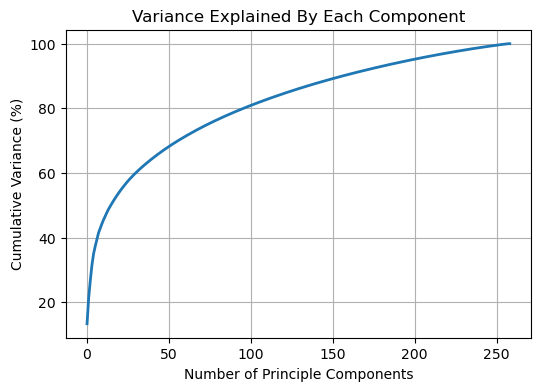

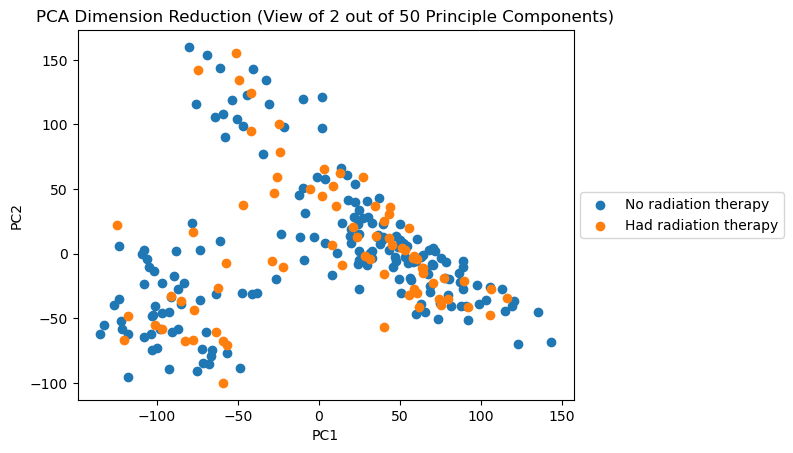

This PC Analysis preserves approximately 68.20815626870579% of the data's information


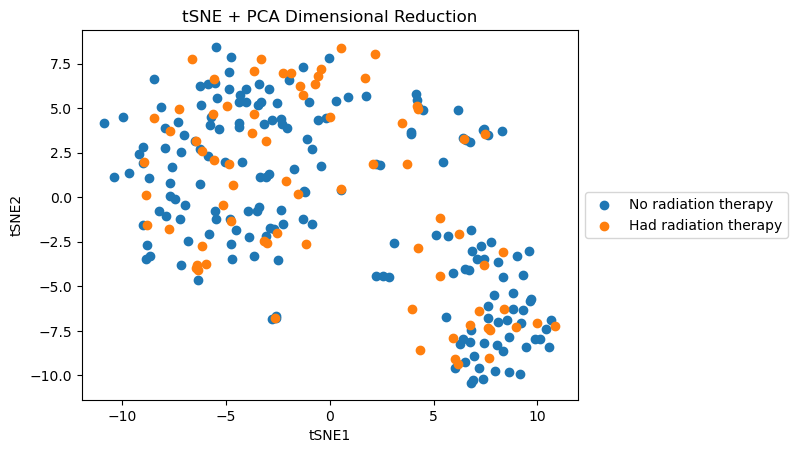

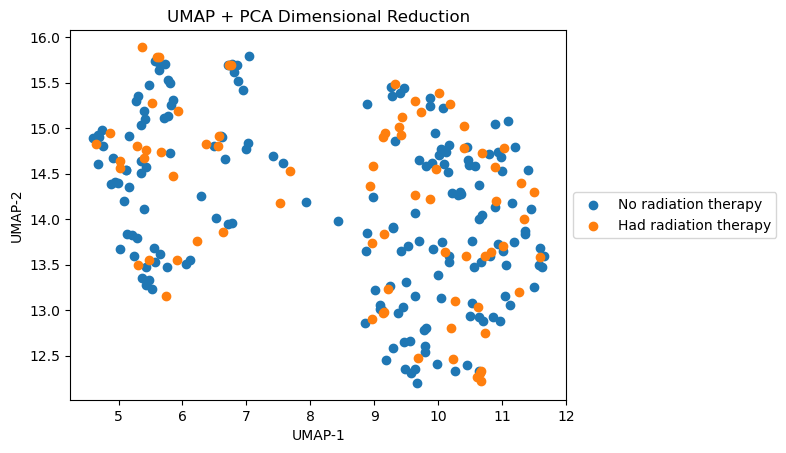

In [65]:
plt.figure(1,figsize=(6,4))
plt.clf()
plt.plot(cum_sum,linewidth=2)
plt.grid()
plt.xlabel('Number of Principle Components')
plt.ylabel('Cumulative Variance (%)')
plt.title('Variance Explained By Each Component')
plt.show()

for code in range(len(legend)):
    temp = figure_pca[figure_pca["code"] == code]
    plt.scatter(temp['PC1'], temp['PC2'])

plt.legend(legend, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA Dimension Reduction (View of 2 out of {rnaseq_pca_shape[1]} Principle Components)")
plt.show()
print(f"This PC Analysis preserves approximately {cum_sum[rnaseq_pca_shape[1]]}% of the data's information")

for code in range(len(legend)):
    temp = figure_tsne[figure_tsne["code"] == code]
    plt.scatter(temp['tSNE1'], temp['tSNE2'])
plt.legend(legend, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.title("tSNE + PCA Dimensional Reduction")
plt.show()

for code in range(len(legend)):
    temp = figure_umap[figure_umap["code"] == code]
    plt.scatter(temp['UMAP-1'], temp['UMAP-2'])
plt.legend(legend, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP + PCA Dimensional Reduction")
plt.show()